# <center>  J2D Project: Preprocesamiento, depuración y análisis de datos del proyecto **ComerçIdeal**


En primer lugar, importamos las librerías principales de Python necesarias para nuestro proyecto.

In [ ]:
import pandas as pd
import numpy as np

Seguidamente, implementamos los datasets dados por el enunciado.

In [ ]:
#1) Precio VENTA de locales comerciales.
df_venta = pd.read_csv('https://opendata-ajuntament.barcelona.cat/data/dataset/1144c2b2-43a5-48f6-b447-5f11a3a34b87/resource/e42cf2cf-a76e-4a32-9357-cf90e0ea8ead/download/locveevolucio.csv')

#2) Precio ALQUILER de locales comerciales.
df_lloguer = pd.read_csv('https://opendata-ajuntament.barcelona.cat/data/dataset/fedae1fc-bd48-4676-afdc-979423786512/resource/97356d26-30b9-436a-8dbb-d0d05f0a87fd/download/loclloevolucio.csv')

#3) Actividades economicas (locales) planta baja (comercios).
tiendas_planta_baja = pd.read_csv('https://opendata-ajuntament.barcelona.cat/data/dataset/62fb990e-4cc3-457a-aea1-497604e15659/resource/c897c912-0f3c-4463-bdf2-a67ee97786ac/download/2019_censcomercialbcn_detall.csv', dtype={35: 'str', 37: 'str'})

#4) Mercados y ferias.
mercados_ferias = pd.read_json('https://opendata-ajuntament.barcelona.cat/data/dataset/067f5ef9-c5c5-452a-ad22-c20f41f2b1ca/resource/cf159ae2-0852-4df0-a7e4-72672dc68998/download/opendatabcn_mercats-centrescomercials_mercats-fires-al-carrer.json')

#5) Mercados municipales
mercados_municipales = pd.read_json('https://opendata-ajuntament.barcelona.cat/data/dataset/706e7507-7f84-480e-940d-23265bf5d853/resource/b204171d-79e3-49d1-9a0a-0bdbb9d46bd2/download/opendatabcn_mercats-centrescomercials_mercats-municipals.json')

#6) Grandes centros comerciales
centros_comerciales = pd.read_json('https://opendata-ajuntament.barcelona.cat/data/dataset/5ce7863c-789a-46b5-977d-c5df4e263f94/resource/214ccb96-16d4-45aa-b0f5-cf8941f52400/download/opendatabcn_mercats-centrescomercials_grans-centres-comercials.json')

#7) GFalerias comerciales
galerias_comerciales=pd.read_json('https://opendata-ajuntament.barcelona.cat/data/dataset/500d773a-a09a-49d3-b521-c2de3961090d/resource/a6e54794-fb4b-4a58-b633-b5ede492bab7/download/opendatabcn_mercats-centrescomercials_galeries-comercials.json')

#1. Introducción

Nuestro objetivo principal en esta primera parte del proyecto es preparar estos datos de manera que podamos identificar patrones significativos y tomar decisiones informadas para futuras expansiones de negocios. Todo ésto recogido en una aplicación que permita el influjo de comercios y consecuentemente, de clientes con el fin de potenciar el comercio local.

#2. Prepocesamiento y depuración de datos

En nuestro caso hemos dividido la depuración de datos en dos procesos diferenciados: (2.1) Depuración previa a la unificación, en el cual hemos tratado los datasets por separado y hemos reducido las variables necesarias y (2.2) Depuración posterior a la unificación, donde hemos seleccionado las variables relevantes del dataset unificado para un fiable tratamiento de datos.

##2.1. Depuración previa a la unificación

##2.1.1. Nuestro dataset base: locals_dt

In [ ]:
locals_dt = tiendas_planta_baja[['Nom_Local','Nom_Via','Porta','Codi_Districte','Nom_Sector_Activitat', 'Codi_Barri', 'Nom_Districte', 'Nom_Activitat','Longitud', 'Latitud']]

In [ ]:
#Creamos una nueva columna '' que indique el nº de locales de la misma actividad en un distrito determinado
locals_dt['Num_Activitats_Districte'] = locals_dt.groupby('Nom_Activitat')['Nom_Districte'].transform('count')

In [ ]:
#Descartamos los datos que contengan información no definida para la simplificación de nuestro dataset
locals_dt = locals_dt[(locals_dt['Nom_Activitat']!= 'Sense informació') | (locals_dt['Nom_Local']!= 'SN')]

In [ ]:
#Añadimos una columa según la disponibilidad de dicho local para alquiler y venta
#limitaremos nuestro dataset para realizar la muestra del proyecto a pequeña escala en nuestra primera versión)

locals_dt['isAvailability'] = np.where((locals_dt['Nom_Sector_Activitat']=='Locals buits en venda i lloguer'), True, False)

In [ ]:
#Añadimos una columna que concatene la dirección completa del local

#1) Eliminar nulos de columna Porta
locals_dt.dropna(subset=['Porta'], inplace=True)
#2) Casteamos la columna Porta a int y str
locals_dt['Porta']=locals_dt['Porta'].astype(int)
locals_dt['Porta']=locals_dt['Porta'].astype(str)
#3) Concatenamos y añadimos una nueva variable
locals_dt['address'] = locals_dt['Nom_Via'] + " " + locals_dt['Porta']


In [ ]:
#Renombramos las variables del dataset
newOrder = ['Nom_Local', 'address', 'Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'isAvailability', 'Nom_Activitat', 'Num_Activitats_Districte','Longitud','Latitud']
locals_dt=locals_dt[newOrder]

rename = ['localName', 'address','districtID','district', 'Codi_Barri', 'isAvailability','activityType','totalDistrictStore','longitude','latitude']
locals_dt.columns = rename

###2.1.2. Nuestro dataset complementario: prices_dt

In [ ]:
#Creamos una lista de columnas a transformar
columnas_cat = ['DOSZEROONZE', 'DOSZERODEU', 'DOSZEROZERONOU', 'DOSZEROZEROVUIT']

In [ ]:
# Iterar sobre cada columna en la lista y convertirla a numérica
for columna in columnas_cat:
    df_lloguer[columna] = pd.to_numeric(df_lloguer[columna], errors='coerce')

for columna in columnas_cat:
    df_venta[columna] = pd.to_numeric(df_venta[columna], errors='coerce')

In [ ]:
#Juntar los 2 conjuntos de datos sobre el numero de Index
df_merged = df_lloguer.merge(df_venta, left_index=True, right_index=True)
df_merged.rename(columns={"DTE_x" : "districtId", "DOSZEROONZE_x" : "2011_rent", "DOSZEROONZE_y":"2011_sales"}, inplace=True)

In [ ]:
#Eliminar las columnas para quedarnos con los precios de alquiler y de venta de 2011
df_merged.drop(columns=['DOSZERODEU_x', 'DOSZEROZERONOU_x', 'DOSZEROZEROVUIT_x', 'DTE_y', 'BARRIS_y', 'DOSZERODEU_y', 'DOSZEROZERONOU_y', 'DOSZEROZEROVUIT_y'], inplace=True)
df_merged

,districtId,BARRIS_x,2011_rent,2011_sales
0,1,1. el Raval,1189.0,2.176
1,1,2. el Barri Gòtic,1325.0,2.632
2,1,3. la Barceloneta,1648.0,2.135
3,1,4. Sant Pere Santa Caterina i la Ribera,1225.0,2.482
4,2,5. el Fort Pienc,921.0,2.224
...,...,...,...,...
68,10,69. Diagonal Mar i el Front Marítim del Poblenou,1126.0,2.651
69,10,70. el Besòs i el Maresme,NaN,2.121
70,10,71. Provençals del Poblenou,832.0,2.255
71,10,72. Sant Martí de Provençals,976.0,1.812


In [ ]:
#Convertir la columna BARRIS_x para extraer el ID de Barrio
df_ID_BARRIO = df_merged['BARRIS_x'].str.split('.', expand=True)

#Añadir la columna ID_BARRIO al dataset df_merged
df_merged['ID_BARRIO'] =  df_ID_BARRIO[0]
df_merged['ID_BARRIO']=df_merged['ID_BARRIO'].astype(int)

#Eliminar la columna de nombre de los Barrios
df_merged.drop(columns='BARRIS_x', inplace=True)

#Cambiar el nombre del dataset
prices_dt = df_merged

In [ ]:
prices_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   districtId  73 non-null     int64  
 1   2011_rent   57 non-null     float64
 2   2011_sales  58 non-null     float64
 3   ID_BARRIO   73 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 2.4 KB


##2.2. Depuración posterior a la unificación

In [ ]:
#Unimos nuestros dos datasets con ID_Barrio como variable común para agrupar los precios de forma correcta
locals_dt=pd.merge(locals_dt, prices_dt, left_on='Codi_Barri', right_on='ID_BARRIO', how='inner')

#Eliminamos las columnas innecesarias o duplicadas
locals_dt.drop(columns=['ID_BARRIO','Codi_Barri','districtId'],inplace=True)

In [ ]:
#Eliminamos las  con valores nulos
locals_dt = locals_dt.dropna()

#Reiniciamos el índice y añadimos un nº identificativo para cada local definido en nuestro dataset
locals_dt.reset_index(inplace=True)
locals_dt['index']=locals_dt['index'].astype(str)
locals_dt['index']= 'loc'+ locals_dt['index']

In [ ]:
#Renombramos las columnas
rename = ['localID','localName', 'address','districtID','district','isAvailability','activityType','totalDistrictStore','longitude','latitude','rentalPrice','salePrice']
locals_dt.columns = rename

In [ ]:
df=locals_dt.copy()

#3. Análisis de datos

Utilizando herramientas de visualización y técnicas estadísticas, exploraremos las características clave que definen la naturaleza de los locales comerciales y su entorno. A través de este análisis, buscamos revelar percepciones valiosas que respalden la toma de decisiones informada y proporcionen una visión clara de los factores que influyen en la dinámica de nuestro conjunto de datos.







###3.1. Scatter plot: Relación entre logitud y latitud

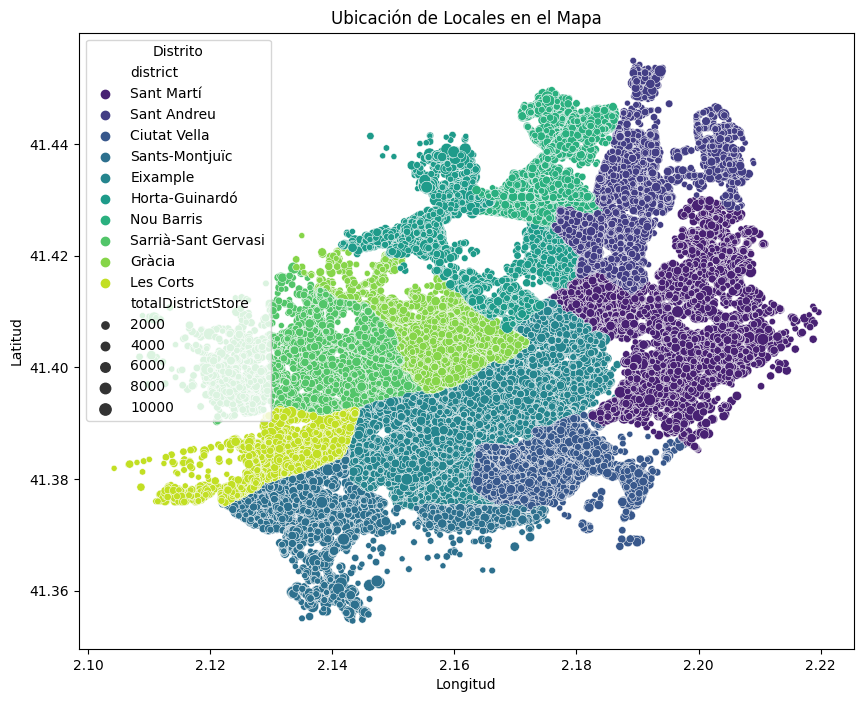

In [ ]:
# Gráfico de dispersión para visualizar la relación entre la longitud y la latitud
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', data=locals_dt, hue='district', palette='viridis', size='totalDistrictStore')
plt.title('Ubicación de Locales en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Distrito')
plt.show()

**Observaciones**
- La extensión de los locales en activo en Barcelona es muy amplia. Este factor será un atenuante para el impacto de nuestro proyecto pues la competencia es la clave para situar un nuevo local en el mapa
- En determinadas coordenadas notamos una gran influencia de tipos de local según su actividad. Este hecho será crucial para nuestro estudio sobre donde posicionar un nuevo local estratégicamente.


###3.2. Scatter plot: Comparación precios de alquiler y venta por distrito

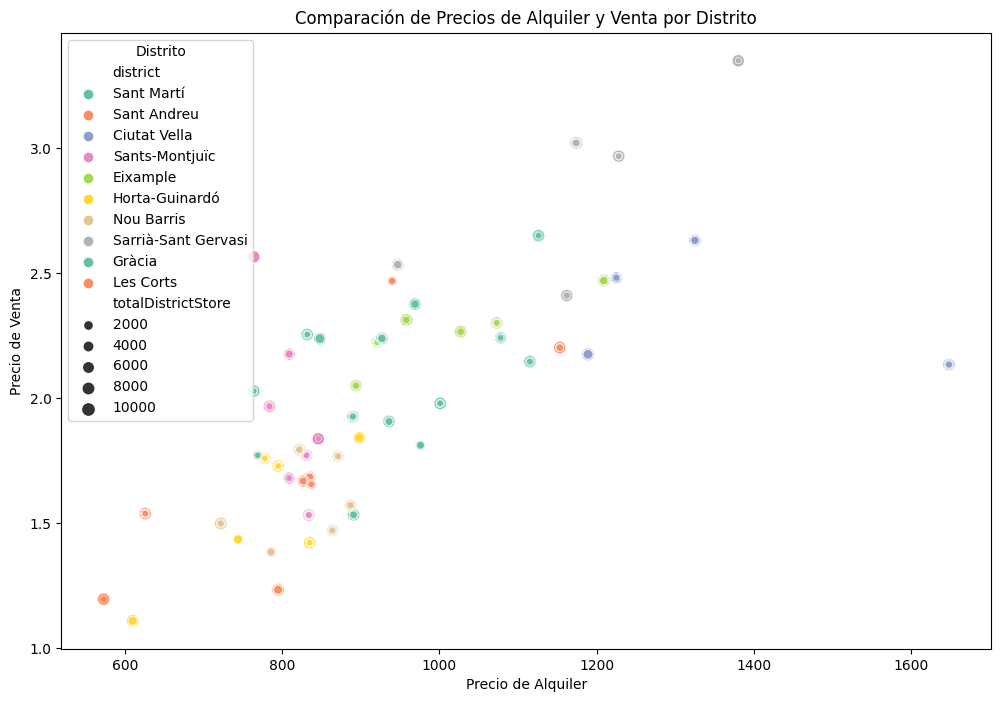

In [ ]:
#Comparación de precios de alquiler y venta por distrito
plt.figure(figsize=(12, 8))
sns.scatterplot(x='rentalPrice', y='salePrice', data=locals_dt, hue='district', size='totalDistrictStore', palette='Set2')
plt.title('Comparación de Precios de Alquiler y Venta por Distrito')
plt.xlabel('Precio de Alquiler')
plt.ylabel('Precio de Venta')
plt.legend(title='Distrito')
plt.show()

**Observaciones**
- Como era de esperar, el precio de alquiler y venta está positivamente correlacionado, es decir, cuanto mayor sea el precio de alquiler, mayor será el de venta, y viceversa.
- Los distritos con mayor precio de alquiler son: 'Ciutat Vella', 'Sarrià-Sant Gervassi' y 'Eixample'.
- Los distritos con mayor precio de venta son: 'Sarrià-Sant Gervassi', 'Sant Marti', 'Ciutat Vella' y 'Eixample'.
- Existe una gran correlación entre el precio de alquiler/venta y el distrito. Hecho que deberemos de tener muy en cuenta para la posterior toma de decisiones.

###3.3. Count plot: Visualización de la distribución de tipos de actividad

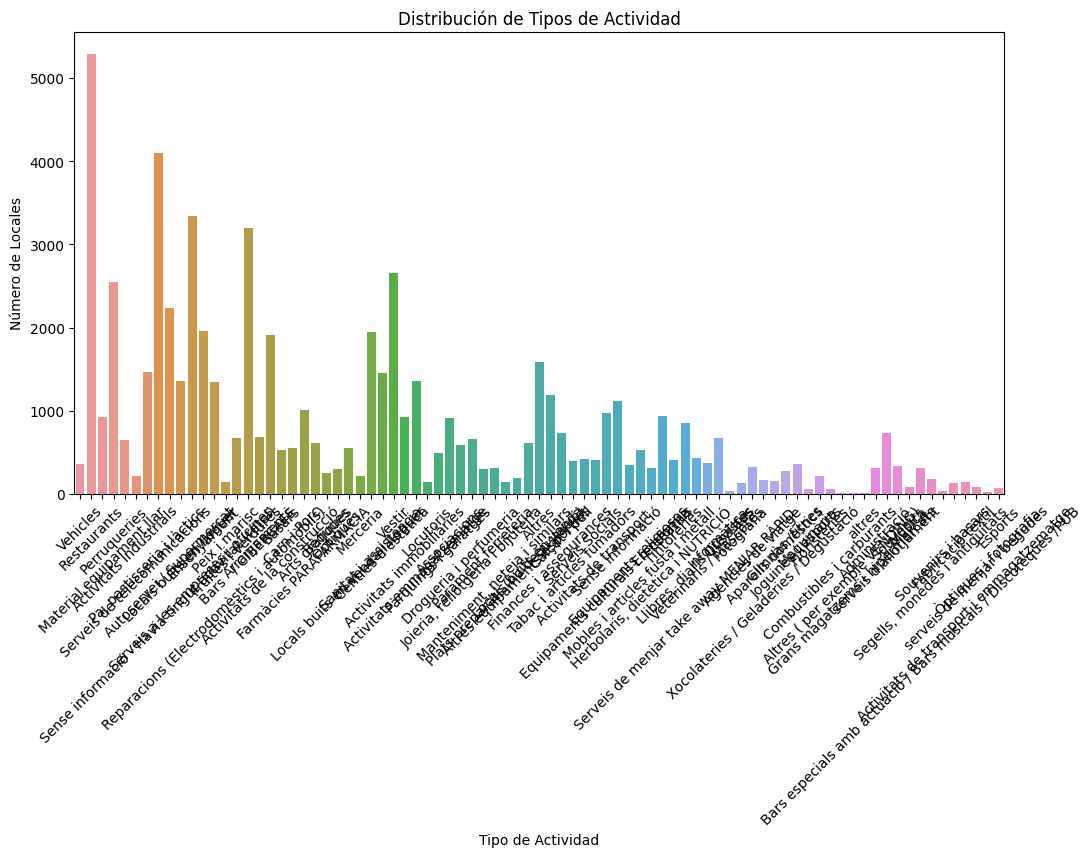

In [ ]:
# Visualización de la distribución de tipos de actividad
plt.figure(figsize=(12, 6))
sns.countplot(x='activityType', data=locals_dt)
plt.title('Distribución de Tipos de Actividad')
plt.xlabel('Tipo de Actividad')
plt.ylabel('Número de Locales')
plt.xticks(rotation=45)
plt.show()

**Observaciones**
- Los tipos de negocio local más comunes son: Restaurants, Serveis a les empreses i oficines, Bars / CIBERCAFÈ, Vestir - Perruqueries
- Por tanto, éstos tienden a ser los más rentables en zonas de influecia, las cuales estudiaremos posteriormente

#4. Muestreo de datos e implementación de la "Milla de oro"

##4.1. Creación de la muestra de datos

Debido a que nuestro dataset tiene un número muy elevado de instancias hemos decidido realizar el análisis de una muestra reducida con tal de probar el potencial de nuestro proyecto.

In [ ]:
# Tu DataFrame original
# Filtrar por "activityType"
selected_activities = ['Restaurants', 'Vestir', 'Bars   / CIBERCAFÈ','Locals buits en venda i lloguer']
filtered_df = df[df['activityType'].isin(selected_activities)]

# Dividir el DataFrame en grupos por "district"
district_groups = filtered_df.groupby('district')

# Función para muestrear 100 muestras por grupo con las condiciones especificadas
def sample_rows(group):
    num_samples = min(100, len(group))
    num_true = int(0.3 * num_samples)
    num_false = num_samples - num_true

    true_rows = group[group['isAvailability'] == True].sample(n=num_true, replace=True)
    false_rows = group[group['isAvailability'] == False].sample(n=num_false, replace=True)

    return pd.concat([true_rows, false_rows])

# Aplicar la función de muestreo a cada grupo y concatenar los resultados
result_df = district_groups.apply(sample_rows).reset_index(drop=True)


In [ ]:
df_insert=result_df.copy()

In [ ]:
df_insert['gold']=False

In [ ]:
#MUESTREO
#result_df.groupby(['district','activityType','isAvailability']).count()

##4.2. Desarrollo de la "Milla de Oro"

In [ ]:
#!pip install statsmodels
#!pip install matplotlib
#!pip install numpy

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

result_df_k=result_df.copy()
result_df_k['key']=result_df_k['district']+result_df_k['activityType']

#KEY
lista_key=result_df_k['key'].unique()

result_df_k_dic={}
result_df_k_dic_target={}


for key in lista_key:
    result_df_k_dic[key]=result_df_k[result_df_k['key']==key]
    #print(key)

for key in lista_key:
    result_df_k_dic_target[key]=result_df_k_dic[key][['latitude','longitude']]


for key in lista_key:
    # creando modelo
    modelo=make_pipeline(MinMaxScaler(),KMeans(n_clusters=4)) #se añade random state por ser estocástica.
    modelo.fit(result_df_k_dic_target[key])

    labels=modelo[1].labels_
    result_df_k_dic_target[key]['clusterVol']=labels
    result_df_k_dic_target[key].drop(columns=['latitude','longitude'],inplace=True)

resultado_concatenado = pd.concat(result_df_k_dic_target.values(), keys=result_df_k_dic_target.keys())

resultado_concatenado.reset_index(inplace=True)
resultado_concatenado['level_1']=resultado_concatenado['level_1'].astype(str)
resultado_concatenado['key_1']=resultado_concatenado['level_0']+resultado_concatenado['level_1']

resultado_concatenado.drop(columns=['level_0','level_1'],inplace=True)
result_df_k.reset_index(inplace=True)

result_df_k['index']=result_df_k['index'].astype(str)
result_df_k['key_1']=result_df_k['key']+result_df_k['index']

result_df_k_f=result_df_k.merge(resultado_concatenado,how='left',on='key_1')

In [105]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

result_df_k=result_df.copy()
result_df_k['key']=result_df_k['district']+result_df_k['activityType']

#KEY
lista_key=result_df_k['key'].unique()

result_df_k_dic={}
result_df_k_dic_target={}


for key in lista_key:
    result_df_k_dic[key]=result_df_k[result_df_k['key']==key]
    #print(key)

for key in lista_key:
    result_df_k_dic_target[key]=result_df_k_dic[key][['latitude','longitude']]


for key in lista_key:
    # creando modelo
    modelo=make_pipeline(MinMaxScaler(),KMeans(n_clusters=4)) #se añade random state por ser estocástica.
    modelo.fit(result_df_k_dic_target[key])

    labels=modelo[1].labels_
    result_df_k_dic_target[key]['clusterVol']=labels
    result_df_k_dic_target[key].drop(columns=['latitude','longitude'],inplace=True)

resultado_concatenado = pd.concat(result_df_k_dic_target.values(), keys=result_df_k_dic_target.keys())

resultado_concatenado.reset_index(inplace=True)
resultado_concatenado['level_1']=resultado_concatenado['level_1'].astype(str)
resultado_concatenado['key_1']=resultado_concatenado['level_0']+resultado_concatenado['level_1']

resultado_concatenado.drop(columns=['level_0','level_1'],inplace=True)
result_df_k.reset_index(inplace=True)

result_df_k['index']=result_df_k['index'].astype(str)
result_df_k['key_1']=result_df_k['key']+result_df_k['index']

result_df_k_f=result_df_k.merge(resultado_concatenado,how='left',on='key_1')

result_df_k_f['clusterVol']=result_df_k_f['clusterVol'].astype(str)
result_df_k_f['key_2']=result_df_k_f['key']+result_df_k_f['clusterVol']

centroides = result_df_k_f.groupby('key_2').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
result_df_k_f = pd.merge(result_df_k_f, centroides, on='key_2', suffixes=('', '_centroid'))

import pandas as pd
from geopy.distance import geodesic



# Función para calcular la distancia geodésica
def calcular_distancia(row):
    coordenadas_actuales = (row['latitude'], row['longitude'])
    coordenadas_centroide = (row['latitude_centroid'], row['longitude_centroid'])
    return geodesic(coordenadas_actuales, coordenadas_centroide).kilometers

# Calcular la distancia para cada fila
result_df_k_f['distancia_al_centroide'] = result_df_k_f.apply(calcular_distancia, axis=1)

result_df_k_f['isGolden'] = np.where(result_df_k_f['distancia_al_centroide'] == result_df_k_f.groupby('key_2')['distancia_al_centroide'].transform('min'), True, False)

output=result_df_k_f[['localID','localName','address','isGolden','districtID','district','isAvailability','activityType','totalDistrictStore','longitude','latitude','rentalPrice','salePrice']]